# Training


In [1]:
import os
import pandas as pd
import numpy as np
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import sklearn.metrics
import scipy.special

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from tensorflow import keras
import h5py
import datetime

In [2]:
rand_gen = np.random.RandomState(41)

HEIGHT = 137
WIDTH = 236

VALIDATION_SPLIT = 98
TEST_SPLIT = 99

In [3]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

To deal with dataset we need to have train/val/test datasets in hdf5 files
use cases:

1. local/colab testing and architecture tuning - train on train, then validate on val and measure final score on test
2. while training final model for submittion - mixup all 3 
3. while ensembling - use val as train for ensemble and test to verify score


4. would be nice to keep class distibution across the datasets, but this can be done later

hdf format is 2 datasets, 1st with pictures, 2nd with labels (same shape across 1 axis)
split size for train could be the same as original files, excluding test


In [4]:
# train_files = [str.format('Data/bengaliai-cv19/train_image_data_{0}.parquet',i) for i in range(4) ]


# train_df = pd.read_csv('Data/bengaliai-cv19/train.csv')
# y_labels = train_df.image_id.copy()
# y_1 = pd.get_dummies(train_df.vowel_diacritic).values
# y_2 = pd.get_dummies(train_df.grapheme_root).values
# y_3 = pd.get_dummies(train_df.consonant_diacritic).values
# y = np.hstack([y_1,y_2,y_3])
# assert(y.shape[1]==11+168+7)
# del train_df, y_1,y_2,y_3
# gc.collect()
# assert (y_labels.shape[0]==y.shape[0])
# n_samples = y.shape[0]

at this point we know the whole DS contains y.shape[0] = y_labels.shape[0] examples and we can split those accordingly

In [5]:
# shuffled_indexes = rand_gen.permutation(y.shape[0])
# train_indexes = shuffled_indexes[:n_samples*VALIDATION_SPLIT//100]
# valid_indexes = shuffled_indexes[n_samples*VALIDATION_SPLIT//100:n_samples*TEST_SPLIT//100]
# test_indexes  = shuffled_indexes[n_samples*TEST_SPLIT//100:]

# valid_images = []
# valid_labels = []
# test_images = []
# test_labels = []

In [6]:
# for i in range(4):
#     chunk_train_indexes = np.compress((train_indexes>=i*50210) & (train_indexes<(i+1)*50210),train_indexes)
#     chunk_valid_indexes = np.compress((valid_indexes>=i*50210) & (valid_indexes<(i+1)*50210),valid_indexes)
#     chunk_test_indexes = np.compress((test_indexes>=i*50210) & (test_indexes<(i+1)*50210),test_indexes)

#     print('loading '+train_files[i])
#     images = pd.read_parquet(train_files[i])
#     # we'd better use numpy indexing instead of combining numpy and pandas (not sure they are 100% consistent)
#     # float 16 is enough to save from parquet to hdf5
#     all_chunk_images = images.iloc[:,1:].values.astype(np.float16).reshape(-1, HEIGHT, WIDTH)/255.0
#     del images
#     gc.collect()

#     # saving train, split by 2 files each
    
#     train_chunk_images = all_chunk_images[chunk_train_indexes-50210*i] # train
#     train_y_chuck = y[chunk_train_indexes]
#     assert(train_y_chuck.shape[0]==train_chunk_images.shape[0])
    
#     train_split_idx = train_y_chuck.shape[0]//2

#     ## Not dry, but can live with it, as it's one time thing
#     train_chunk_0_fname = str.format('Data/bengaliai-cv19/train_image_data_processed{0}.hdf5',2*i)
#     h5f = h5py.File(train_chunk_0_fname, 'w')
#     h5f.create_dataset('images', data = train_chunk_images[:train_split_idx])
#     h5f.create_dataset('labels', data = train_y_chuck[:train_split_idx])
#     h5f.close()
#     print('saved '+train_chunk_0_fname)

#     train_chunk_1_fname = str.format('Data/bengaliai-cv19/train_image_data_processed{0}.hdf5',2*i+1)
#     h5f = h5py.File(train_chunk_1_fname, 'w')
#     h5f.create_dataset('images', data = train_chunk_images[train_split_idx:])
#     h5f.create_dataset('labels', data = train_y_chuck[train_split_idx:])
#     h5f.close()
#     print('saved '+train_chunk_1_fname)


#     ## for reading - 
#     # In [10]: h5f = h5py.File('data.h5','r')
#     # In [11]: b = h5f['dataset_1'][:]
#     # In [12]: h5f.close()

#     chunk_valid_images = all_chunk_images[chunk_valid_indexes-50210*i] # valid
#     chunk_valid_labels = y[chunk_valid_indexes]
#     assert(chunk_valid_labels.shape[0]==chunk_valid_images.shape[0])
#     valid_images.append(chunk_valid_images)
#     valid_labels.append(chunk_valid_labels)

#     chunk_test_images = all_chunk_images[chunk_test_indexes-50210*i] # test
#     chunk_test_labels = y[chunk_test_indexes]
#     assert(chunk_test_labels.shape[0]==chunk_test_images.shape[0])
#     test_images.append(chunk_test_images)
#     test_labels.append(chunk_test_labels)

#     del train_chunk_images, train_y_chuck
#     gc.collect()
#     print('completed '+train_files[i])

In [7]:
# saving valid and test 

# valid_images_all = np.vstack(valid_images)
# valid_labels_all = np.vstack(valid_labels)
# test_images_all = np.vstack(test_images)
# test_labels_all = np.vstack(test_labels)

# ## Not dry, but can live with it, as it's one time thing
# h5f = h5py.File('Data/bengaliai-cv19/valid_image_data_processed.hdf5', 'w')
# h5f.create_dataset('images', data = valid_images_all)
# h5f.create_dataset('labels', data = valid_labels_all)
# h5f.close()

# h5f = h5py.File('Data/bengaliai-cv19/test_image_data_processed.hdf5', 'w')
# h5f.create_dataset('images', data = test_images_all)
# h5f.create_dataset('labels', data = test_labels_all)
# h5f.close()

# del valid_images,valid_labels,test_images,test_labels
# del valid_images_all,valid_labels_all,test_images_all,test_labels_all
# gc.collect()

In [8]:
def images_generator(batch_size):
    
    files = [str.format('Data/bengaliai-cv19/train_image_data_processed{0}.hdf5',i) for i in range(8) ]
    current_file_idx = 0
    already_send = 0     
    steps = 0
    
    while True:
#     ## for reading - 
#     # In [10]: h5f = h5py.File('data.h5','r')
#     # In [11]: b = h5f['dataset_1'][:]
#     # In [12]: h5f.close()
        h5f = h5py.File(files[current_file_idx],'r')
        train_X = h5f['images'][:]
        train_Y = h5f['labels'][:]        
        h5f.close()        
#         print("loaded "+str(files[current_file_idx])+ " with size "+str(train_X.shape))        
        
        while (already_send<train_X.shape[0]):
            if (already_send+batch_size<train_X.shape[0]):
                train_batch_X = train_X[already_send:already_send+batch_size,:]
                train_batch_Y = train_Y[already_send:already_send+batch_size,:]
            else:
                train_batch_X = train_X[already_send:,:]
                train_batch_Y = train_Y[already_send:,:]
            assert (train_batch_X.shape[0]==train_batch_Y.shape[0])                
            steps+=1
#             print("sending "+str(already_send) + " steps " + str(steps))
            
            yield np.expand_dims(train_batch_X,axis=3), train_batch_Y
            already_send+=batch_size

#         print("file completed, swithing to next. Steps = "+str(steps))
        already_send=0
        current_file_idx+=1
        if (current_file_idx==8):
            current_file_idx = 0

In [9]:
valid_file_name = 'Data/bengaliai-cv19/valid_image_data_processed.hdf5'
h5f = h5py.File(valid_file_name,'r')
valid_X = np.expand_dims(h5f['images'][:],axis=3)
valid_Y = h5f['labels'][:]
h5f.close()

In [10]:
def build_model():
    '''
    Constructs the ML model used to predict handwritten digits.
    Taken from https://github.com/tensorflow/models/blob/master/official/vision/image_classification/mnist_main.py
    '''
    image = tf.keras.layers.Input(shape=(137, 236, 1))
    y = tf.keras.layers.Conv2D(filters=32,
                             kernel_size=5,
                             padding='same',
                             activation='relu')(image)

    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                   strides=(2, 2),
                                   padding='same')(y)
    
    y = tf.keras.layers.Conv2D(filters=32,
                             kernel_size=5,
                             padding='same',
                             activation='relu')(y)
    
    y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                   strides=(2, 2),
                                   padding='same')(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(1024, activation='relu')(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    
#     out_m = tf.keras.layers.Dense(186, activation='sigmoid')(y)
    
    out_0 = tf.keras.layers.Dense(11, activation='softmax')(y)
    out_1 = tf.keras.layers.Dense(168, activation='softmax')(y)
    out_2 = tf.keras.layers.Dense(7, activation='softmax')(y)
    
    out_m=tf.concat(values=[out_0,out_1,out_2],axis=1)
        
#         # vowel_diacritic
#         self.fc1 = nn.Linear(512,11)
#         # grapheme_root
#         self.fc2 = nn.Linear(512,168)
#         # consonant_diacritic
#         self.fc3 = nn.Linear(512,7)

#     probs = tf.keras.layers.Dense(10, activation='softmax')(y)

#      Idea of multiclass classification from the link below - replace activation with sigmoid
#    loss="binary_crossentropy", metrics=["accuracy"]
#     https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

    model = tf.keras.models.Model(image, out_m, name='bengali')

    return model

In [11]:
# history = model.fit(
#       np.expand_dims(X_train,axis=3),y_train,
#       epochs=3,
#       batch_size=64,
#       validation_data=(np.expand_dims(X_test,axis=3),y_test)
# #       steps_per_epoch=train_steps,
# #       callbacks=callbacks,
# #       validation_steps=num_eval_steps,
# #       validation_data=eval_input_dataset,
# #       validation_freq=flags_obj.epochs_between_evals
# )

In [12]:
# def customLoss(yTrue,yPred):
#     return keras.losses.categorical_crossentropy(yTrue[:,0:11],yPred[:,0:11])+\
#         2*keras.losses.categorical_crossentropy(yTrue[:,11:179],yPred[:,11:179])+\
#         keras.losses.categorical_crossentropy(yTrue[:,179:186],yPred[:,179:186])


In [13]:
# # https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras 
# # -> https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7

# def recall(y_true, y_pred):
#     """Recall metric.
#     Only computes a batch-wise average of recall.
#     Computes the recall, a metric for multi-label classification of
#     how many relevant items are selected.
#     """
#     true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
#     possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + keras.backend.epsilon())
#     return recall

In [14]:
# def customMetric(yTrue,yPred):
# #     return keras.metrics.Recall(yTrue,yPred)
#     return keras.metrics.Recall(yTrue[:,0:11],yPred[:,0:11])

In [15]:
# customMetric(valid_Y,predictions)

In [16]:
model = build_model()

model.compile(
    optimizer=keras.optimizers.Adam(),
#     loss=customLoss,
    loss = keras.losses.binary_crossentropy,
    metrics=['binary_accuracy',keras.metrics.Recall()])

model_fname = 'models/model-' + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.metrics[1].name

'recall'

In [18]:
# Callbacks reused from 
# https://www.kaggle.com/deshwalmahesh/bengali-ai-complete-beginner-tutorial-95-acc
    
import tensorflow.keras.callbacks as cb 

R_LR_P = cb.ReduceLROnPlateau(monitor='val_recall',patience=3,verbose=1,factor=0.5,min_lr=0.00001,mode='max')
# if validation loss of out_1 is not decreasing for 3 consecutive epochs, decrease the learning rate by 0.5 
# given if learning rate is above 0.00001 and give us little insight on what has happened verbose=1

ES = cb.EarlyStopping(monitor='val_recall',patience=4, min_delta=0.0025,mode='max')
# stop the model from fitting data if validation loss has not decreased by 0.0025 in the last 5 epochs

MCP = cb.ModelCheckpoint(model_fname+'.hdf5', monitor ='val_recall', verbose =1, 
                      save_best_only = True, save_weights_only=True,mode='max')
# save the weights in a file name specified only if the validation loss of out_1 layer has improved from 
# last save. out_1 because it's recall matters twice 

callbacks = [R_LR_P,ES,MCP]

# serialize model to JSON
model_json = model.to_json()
with open(model_fname+'.json', "w") as json_file:
    json_file.write(model_json)



In [19]:
history = model.fit(
      images_generator(batch_size=64),
      epochs=12,
      steps_per_epoch=3080,
      validation_data = (valid_X, valid_Y),
      callbacks=callbacks
)

Epoch 1/12
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2008/3080 [==================>...........] - ETA: 0s - loss: 0.0348 - binary_accuracy: 0.9901 - recall: 0.4875
Epoch 00001: val_recall improved from -inf to 0.48755, saving model to models/model-2020-01-12-19-19.hdf5
3080/3080 [==============================] - 139s 45ms/step - loss: 0.0430 - binary_accuracy: 0.9884 - recall: 0.4016 - val_loss: 0.0348 - val_binary_accuracy: 0.9901 - val_recall: 0.4875
Epoch 2/12
1968/3080 [==================>...........] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9916 - recall: 0.5732
Epoch 00002: val_recall improved from 0.48755 to 0.57337, saving model to models/model-2020-01-12-19-19.hdf5
3080/3080 [==============================] - 131s 43ms/step - loss: 0.0326 - binary_accuracy: 0.9904 - recall: 0.5192 - val_loss: 0.0273 - val_binary_accuracy: 0.9916 - val_recall: 0.5734
Epoch 3/12
1952/3080 [==================>...........] - ETA: 0s - loss:

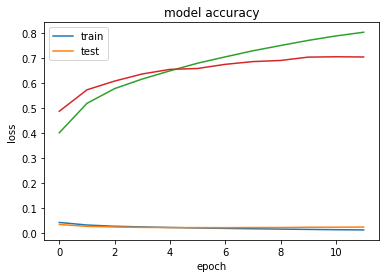

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# model_fname = 'models/model-2020-01-04-11-33'
model_fname = 'models/model-2020-01-09-06-03'
# model_fname = 'models/model-2020-01-12-19-19'

In [36]:
# Separate inference phase

import tensorflow.keras.models
# load json and create model
json_file = open(model_fname+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_fname+'.hdf5')
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer=keras.optimizers.Adam(),
#     loss=customLoss,
    loss = keras.losses.binary_crossentropy,
    metrics=['binary_accuracy',keras.metrics.Recall()])
score = loaded_model.evaluate(valid_X, valid_Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
binary_accuracy: 99.26%


In [37]:
print(loaded_model.metrics_names)
print(score)

['loss', 'binary_accuracy', 'recall_3']
[0.024003607736700086, 0.99263954, 0.61387783]


### Metric from rules
```
import numpy as np
import sklearn.metrics

scores = []
for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
    y_true_subset = solution[solution[component] == component]['target'].values
    y_pred_subset = submission[submission[component] == component]['target'].values
    scores.append(sklearn.metrics.recall_score(
        y_true_subset, y_pred_subset, average='macro'))
final_score = np.average(scores, weights=[2,1,1])
```
also keep in mind target is constructed as
```
y_1 = pd.get_dummies(train_df.vowel_diacritic).values
y_2 = pd.get_dummies(train_df.grapheme_root).values
y_3 = pd.get_dummies(train_df.consonant_diacritic).values
assert(y.shape[1]==11+168+7)
del train_df, y_1,y_2,y_3
```

plan: 
1. get prediction on validation set
2. try to compute metric for val set 
3. try to incorporate metric into training

In [38]:
predictions=loaded_model.predict(valid_X)

In [39]:
assert(valid_Y.shape==predictions.shape)

In [40]:
scores = []

for intervals in [(0,11),(11,179),(179,186)]:    
    y_true_subset = valid_Y[:,intervals[0]:intervals[1]]
    y_pred_subset = predictions[:,intervals[0]:intervals[1]]
    #"hard" max
    y_pred_choice = np.zeros(y_pred_subset.shape, dtype='uint8')
    y_pred_choice[np.arange(len(y_pred_subset)), y_pred_subset.argmax(axis=1)] = 1   
    
    partical_score = sklearn.metrics.recall_score(
        y_true_subset, y_pred_choice, average='macro')
    scores.append(partical_score)
    
    print('for '+str(intervals)+ ' score is '+str(partical_score))
    

final_score = np.average(scores, weights=[1,2,1])
print()
print('TOTAL: '+str(final_score))

for (0, 11) score is 0.8016213740678662
for (11, 179) score is 0.4136798279457808
for (179, 186) score is 0.7025289942805701

TOTAL: 0.5828775060599996


In [28]:
# for model-2020-01-12-19-19
# for (0, 11) score is 0.8161456276283384
# for (11, 179) score is 0.41152848969600087
# for (179, 186) score is 0.6923909632987134

# TOTAL: 0.5828983925797634

# AND 

# for (0, 11) score is 0.8016213740678662
# for (11, 179) score is 0.4136798279457808
# for (179, 186) score is 0.7025289942805701

# TOTAL: 0.5828775060599996


for (0, 11) score is 0.8161456276283384
for (11, 179) score is 0.41152848969600087
for (179, 186) score is 0.6923909632987134

TOTAL: 0.5828983925797634


Outcome

| Model                       |file name | Local Recall   |LB score |  Ep |Comment|
|-----------------------------|----------|----------------|---------|-----|-----------|
| mnist_main (186 Dense out), custom loss  | model-2020-01-09-05-43 |0.0614  |  | 6  |Seems there is a bug because keras recall doesn't equal recall per model|
| mnist_main (186 Dense out), binary_crossenthropy loss | model-2020-01-09-06-03 |0.5828 | 0.5723 | 6 | Custom loss makes training much worse|
| mnist_main (3x softmax out) |model-2020-01-12-19-19 | 0.5829 | N/A | 11 | Doesn't makes much sence to submit
